In [32]:
%matplotlib inline
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re

In [103]:
def read_cvrp(basename, path):
    def str2int(values):
        return [int(float(x.strip())) for x in values]

    task_file = os.path.join(path, basename + '.vrp')
    
    split_name = re.compile(r'(?P<group>\w)-n(?P<dim>\d+)-k(?P<vehicles>\d+)')
    non_numeric = re.compile(r'[^\d]+')

    nodes = {}
    demands = {}
    depot = None
    vehicles = None
    read_mode = None

    with open(task_file, 'r') as task:
        for r in task:
            if r.startswith('NAME'):
                name = r.split(' ')[-1].strip()
            elif r.startswith('DIMENSION'):
                dimension = non_numeric.sub('', r)
            elif r.startswith('CAPACITY'):
                capacity = non_numeric.sub('', r)
            elif r.startswith('VEHICLES'):
                vehicles = non_numeric.sub('', r)
            elif r.startswith('NODE_COORD_SECTION'):
                read_mode = 'node'
            elif r.startswith('DEMAND_SECTION'):
                read_mode = 'demand'
            elif r.startswith('DEPOT_SECTION'):
                read_mode = 'depot'
            elif read_mode == 'node':
                node = re.split('\s+', r.strip())
                nodes[int(node[0])] = str2int(node[1:])
            elif read_mode == 'demand':
                demand = re.split('\s+', r.strip())
                demands[int(demand[0])] = str2int(demand[1:])
            elif read_mode == 'depot':
                coord = re.split('\s+', r.strip())

                if len(coord) == 2:
                    key = min(nodes.keys()) - 1
                    depot = str2int(coord)
                    nodes[key] = depot
                else:
                    depot = nodes[1]

                read_mode = None

    nodes = np.array([[k] + i + demands[k] for (k, i) in nodes.items()])
    depot = nodes[0, 1:3]
                
    if vehicles is None:
        m_name = re.match(split_name, name)
        m_file = re.match(split_name, basename)

        if m_name:
            vehicles = m_name.group('vehicles')
        elif m_file:
            vehicles = m_file.group('vehicles')
        else:
            raise Exception('Cannot determine number of vehicles for %s' % basename)

    routes = []
    cost = None

    if os.path.exists(os.path.join(path, basename + '.opt')):
        with open(os.path.join(path, basename + '.opt'), 'r') as sol:
            for r in sol:
                if r.startswith('Route'):
                    routes.append(str2int(r.split(':')[1].strip().split(' ')))
                elif r.startswith('cost'):
                    cost = non_numeric.sub('', r)
    elif os.path.exists(os.path.join(path, basename + '.sol')):
        with open(os.path.join(path, basename + '.sol'), 'r') as sol:
            for i, r in enumerate(sol):
                if i == 1:
                    cost = float(r)
                elif i < 3:
                    continue
                
                vehicle = re.split('\s+', r.strip())
                routes.append(str2int(vehicle[5:]))
                
    return vehicles, capacity, nodes, depot, routes, cost

In [129]:
def scale(nodes, factor):
    nodes[:, 1:3] = nodes[:, 1:3] * factor
    return nodes
            

def rotate(nodes, rotation):
    x0 = 500
    y0 = 500
   
    x2 = np.cos(rotation) * (nodes[:, 1] - x0) - np.sin(rotation) * (nodes[:, 2] - y0) + x0
    y2 = np.sin(rotation) * (nodes[:, 1] - x0) - np.cos(rotation) * (nodes[:, 2] - y0) + y0
    nodes[:, 1] = x2
    nodes[:, 2] = y2
    return nodes        


def translate(nodes, x, y):
    nodes[:, 1] += x
    nodes[:, 2] += y
    return nodes


def mirror(nodes, m):
    if m[0] == 1:
        nodes[:, 1] = 1000 - nodes[:, 1]
        
    if m[1] == 1:
        nodes[:, 2] = 1000 - nodes[:, 2]
        
    if m[2] == 1:
        nodes[:, [1, 2]] = nodes[:, [2, 1]]
    
    if m[3] == 1:
        nodes[:, [1, 2]] = 1000 - nodes[:, [2, 1]]
    
    return nodes


def reorder(nodes, routes):
    new_ids = range(2, len(nodes)+1)
    np.random.shuffle(new_ids)
    id_match = np.array([range(2, len(nodes)+1), new_ids])
    
    nodes[1:, 0] = new_ids
    
    new_routes = []
    
    for r in routes:
        nr = []
        for s in r:
            nr.append(id_match[id_match[:,0] == s, 1])
            
        new_routes.append(nr)
            
    return nodes, routes
    

def all_transforms(nodes, routes, no_shifts=5, shuffles=3):
    rotations = [0] #, np.pi/2, np.pi, 1.5*np.pi]
    mirrors = itertools.product(range(2), repeat=4)
    
    x_shift = np.random.randint(min(0, -nodes[:, 1].min()), max(0, 1000-nodes[:, 1].max()), no_shifts)
    y_shift = np.random.randint(min(0, -nodes[:, 2].min()), max(0, 1000-nodes[:, 2].max()), no_shifts)
    shifts = zip(x_shift, y_shift)
    
    for rot in rotations:
        for m in mirrors:
            for shift in shifts:
                for shuffle in range(shuffles+1):
                     yield transform(nodes, routes, rot, m, shift, shuffle)
    

def transform(nodes, routes, rotation, m, shift, shuffle):
    # Rotate
    nodes = rotate(nodes, rotation)
    
    # Translate
    nodes = translate(nodes, shift[0], shift[1])
    
    # Mirror
    nodes = mirror(nodes, m)
    
    # Reorder
    if shuffle > 0:
        nodes, routes = reorder(nodes, routes)
    
    return nodes, routes

entities = 0
ignore_list = ['cvrp/E', 'cvrp/F', 'cvrp/Li', 'cvrp/CMT', 'cvrp/Golden', 'cvrp/tai', 'cvrp/Software']

with open('data/cvrp_sep_train.txt', 'w') as sep_train, open('data/cvrp_sep_test.txt', 'w') as sep_test, \
   open('data/cvrp_unsep_train.txt', 'w') as unsep_train, open('data/cvrp_unsep_test.txt', 'w') as unsep_test:
    for path, f in set([(os.path.dirname(x), os.path.splitext(os.path.basename(x))[0]) for x in glob.glob('cvrp/*/*')]):
        if path in ignore_list:
            continue
        
        try:
            vehicles, capacity, nodes, depot, routes, cost = read_cvrp(f, path)
        except Exception as e:
            print('Error on %s: %s' % (f, e))
            continue
        x_full = []
        y_full = []
        
        if path in ['cvrp/A', 'cvrp/B', 'cvrp/M', 'cvrp/P']:
            nodes = scale(nodes, 10)

        for tnodes, troutes in all_transforms(nodes, routes, no_shifts=10, shuffles=5):
            x_nodes = tnodes[:, 1:].reshape(-1).tolist()
            x = [vehicles, capacity, -1] + x_nodes

            y_unsep = [n for r in troutes for n in r]
            y_sep = list(itertools.chain.from_iterable([l + [-1] for l in troutes]))

            if np.random.rand() < 0.2:            
                for r in (x, y_sep, y_unsep):
                    sep_test.write(' '.join(str(ex) for ex in x) + ' output ' + ' '.join(str(ex) for ex in y_sep) + '\n')
                    unsep_test.write(' '.join(str(ex) for ex in x) + ' output ' + ' '.join(str(ex) for ex in y_unsep) + '\n')
            else:
                for r in (x, y_sep, y_unsep):
                    sep_train.write(' '.join(str(ex) for ex in x) + ' output ' + ' '.join(str(ex) for ex in y_sep) + '\n')
                    unsep_train.write(' '.join(str(ex) for ex in x) + ' output ' + ' '.join(str(ex) for ex in y_unsep) + '\n')
                    
            entities += 1

ValueError: low >= high

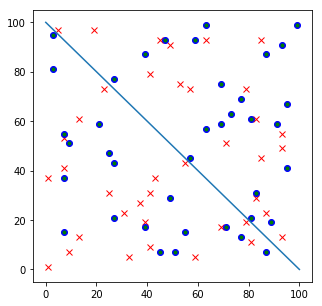

In [58]:
plt.plot(nds[:, 1], nds[:, 2], 'rx')
plt.plot(100-nds[:, 2], 100-nds[:, 1], 'bo')
plt.plot(100-nds[:, 2], 100-nds[:, 1], 'g.')
plt.plot([0, 100], [100, 0])
plt.gcf().set_size_inches(5, 5)